In [4]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import os
%matplotlib inline

In [5]:
PATH = r"Dataset"
CATEGORIES = ["with_mask", "without_mask"]

In [6]:
data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(PATH, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)
        data.append(image)
        labels.append(category)

In [7]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

In [8]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,
                                                  test_size=0.20, stratify=labels, random_state=42)

In [9]:
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [10]:
Mobile = MobileNetV2(weights="imagenet", include_top=False,
                    input_tensor=Input(shape=(224, 224, 3)))

9412608/9406464 [==============================] - 21s 2us/step


In [11]:
headModel = AveragePooling2D(pool_size=(7, 7))(Mobile.output)
headModel = Flatten(name="flatten")(Mobile.output)
headModel = Dense(128, activation="relu")(Mobile.output)
headModel = Dropout(0.5)(Mobile.output)
headModel = Dense(2, activation="softmax")(Mobile.output)

In [12]:
model = Model(inputs=Mobile.input, outputs=Mobile.output)

In [13]:
LR = 1e-5
EPOCHS = 35
BS = 32

In [14]:
for layer in Mobile.layers:
    layer.trainable = False

In [15]:
opt = Adam(lr=LR, decay=LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
              metrics=["accuracy"])

In [16]:
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

Epoch 1/35
37/37 [==============================] - 50s 1s/step - loss: 0.8675 - accuracy: 0.5456 - val_loss: 0.6370 - val_accuracy: 0.6325
Epoch 2/35
37/37 [==============================] - 35s 950ms/step - loss: 0.6796 - accuracy: 0.6326 - val_loss: 0.5049 - val_accuracy: 0.7815
Epoch 3/35
37/37 [==============================] - 31s 845ms/step - loss: 0.5570 - accuracy: 0.7050 - val_loss: 0.3997 - val_accuracy: 0.8874
Epoch 4/35
37/37 [==============================] - 32s 861ms/step - loss: 0.4664 - accuracy: 0.7621 - val_loss: 0.3265 - val_accuracy: 0.9470
Epoch 5/35
37/37 [==============================] - 31s 827ms/step - loss: 0.4178 - accuracy: 0.8107 - val_loss: 0.2729 - val_accuracy: 0.9636
Epoch 6/35
37/37 [==============================] - 32s 875ms/step - loss: 0.3404 - accuracy: 0.8627 - val_loss: 0.2318 - val_accuracy: 0.9702
Epoch 7/35
37/37 [==============================] - 31s 840ms/step - loss: 0.2980 - accuracy: 0.8866 - val_loss: 0.1989 - val_accuracy: 0.9801
Ep

In [17]:
predIdxs = model.predict(testX, batch_size=BS)

In [18]:
predIdxs = np.argmax(predIdxs, axis=1)

In [20]:
print(classification_report(testY.argmax(axis=1), predIdxs))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       151
           1       0.99      0.99      0.99       151

    accuracy                           0.99       302
   macro avg       0.99      0.99      0.99       302
weighted avg       0.99      0.99      0.99       302



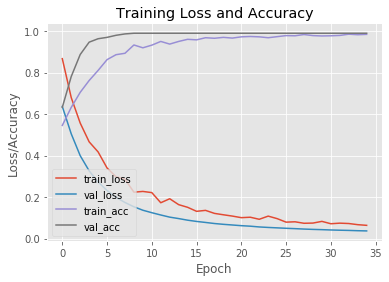

In [21]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, EPOCHS), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, EPOCHS), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, EPOCHS), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, EPOCHS), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [22]:
model.save("mask_detector1.model", save_format="h5")